# Module 5.1 — Drifting Expectancy

## Objective
This submodule explores gradual parameter instability in a probabilistic system.

We simulate a world where:
- Win rate slowly declines from 55% to 48% over 1000 trades.
- Risk/reward remains constant.
- No abrupt break occurs.

## Core Question
How long can structural degradation hide inside normal variance?

We examine:
- Equity curve behavior
- Rolling win rate
- Rolling expectancy

The goal is to understand how slowly changing probabilities affect detection, interpretation, and perceived system health — without introducing strategy adjustments or optimization logic.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

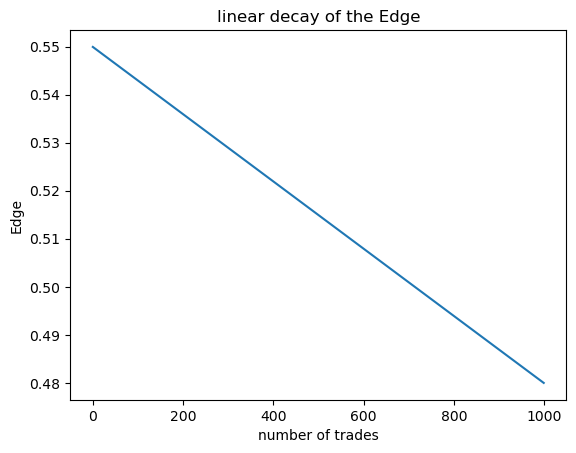

In [2]:
n_trades = 1000
win = 1        
loss = -1
t = np.arange(1,n_trades+1)
p = 0.55 -(0.07*(t/1000))       # degrading edge form 55% to 48% linearly

plt.figure()
plt.plot(p)
plt.ylabel('Edge')
plt.xlabel('number of trades')
plt.title('linear decay of the Edge')

plt.show()

## Single drifting Path

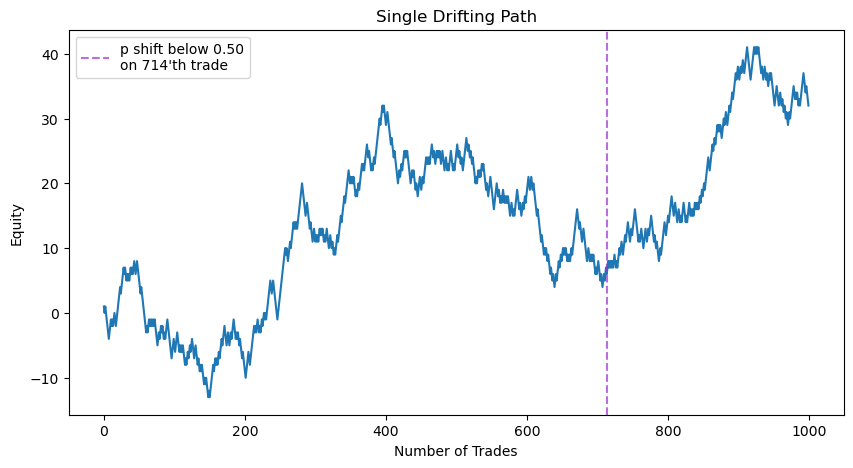

In [3]:
seq = np.where(
    np.random.rand(n_trades) < p,
    win,
    loss
)

path = np.cumsum(seq)

plt.figure(figsize = (10, 5))
plt.plot(path)
plt.xlabel('Number of Trades')
plt.ylabel('Equity')
plt.title('Single Drifting Path')
shift = np.argwhere( p < 0.50)[0][0]
plt.axvline(x = shift, alpha = 0.7, linestyle = '--', c ='darkorchid', label = f"p shift below 0.50\non {shift}'th trade")
plt.legend()

plt.show()

## Rolling Win Rate

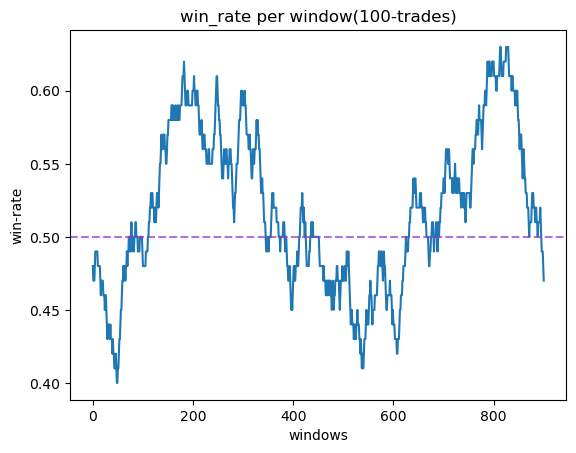

In [4]:
window = 100   # 100 trades per window
patch = sliding_window_view(seq , window)
patch = np.where(patch == win, 1, 0)
win_rates = patch.mean(axis = 1)

plt.figure()
plt.plot(win_rates)
plt.axhline(y = 0.50, alpha = 0.7, linestyle = '--', c ='darkorchid')

plt.xlabel('windows')
plt.ylabel('win-rate')
plt.title(f'win_rate per window({window}-trades)')

plt.show()

## Rolling Expectancy

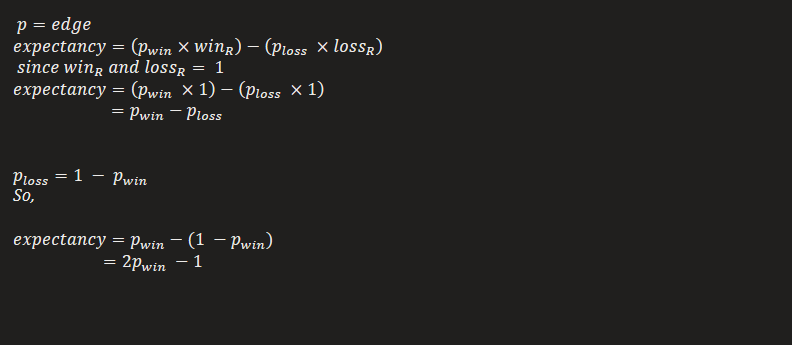

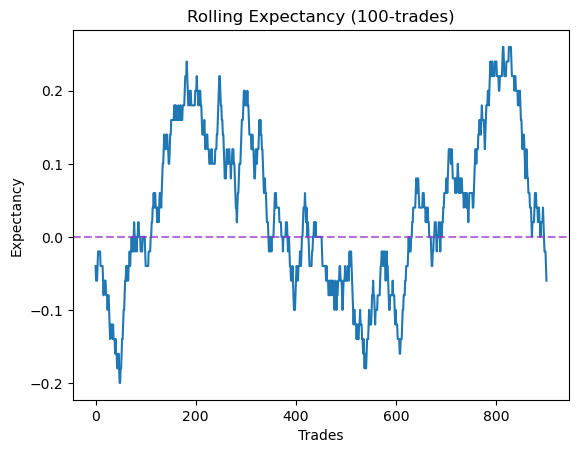

In [5]:
rolling_expectancy = 2 * win_rates - 1

plt.figure()
plt.plot(rolling_expectancy)
plt.axhline(y = 0.0, alpha = 0.7, linestyle = '--', c ='darkorchid' )

plt.title(f"Rolling Expectancy ({window}-trades)")
plt.xlabel('Trades')
plt.ylabel('Expectancy')

plt.show()

## Monte Carlo Repetition

In [6]:
def simulate_drift(n_trades = 1000, window = 100):
    t = np.arange(1, n_trades + 1)
    p = 0.55 - (0.07 * (t / 1000))

    seq = np.where(np.random.rand(n_trades) < p, 1, -1)

    equity = np.cumsum(seq)

    # Rolling win rate (overlapping)
    wins = np.where(seq == 1, 1, 0)
    rolling_win = sliding_window_view(wins, window).mean(axis = 1)

    # Rolling expectancy (direct mean of R)
    rolling_exp = sliding_window_view(seq, window).mean(axis=1)

    # Detection points
    win_detect = np.where(rolling_win < 0.50)[0]
    exp_detect = np.where(rolling_exp < 0)[0]
    
    win_detect_trade = (win_detect[0] + window - 1) if len(win_detect) > 0 else None
    exp_detect_trade = (exp_detect[0]+ window - 1)if len(exp_detect) > 0 else None
    
    return {
        "final_equity": equity[-1],
        "win_detect": win_detect_trade,
        "exp_detect": exp_detect_trade
    }
    

In [7]:
n_runs = 25
results = [simulate_drift() for _ in range(n_runs)]

final_equities = [r["final_equity"] for r in results]

win_detection_times = [r["win_detect"] for r in results if r["win_detect"] is not None]
exp_detection_times = [r["exp_detect"] for r in results if r["exp_detect"] is not None]

print(f"Mean win-rate detection (win-rate < 0.50): {np.mean(win_detection_times):.0f}th trade")
print(f"Mean expectancy detection (expectancy < 0): {np.mean(exp_detection_times):.0f}th trade")


Mean win-rate detection (win-rate < 0.50): 248th trade
Mean expectancy detection (expectancy < 0): 248th trade


In [8]:
win_no_detect = sum(r["win_detect"] is None for r in results)
exp_no_detect = sum(r["exp_detect"] is None for r in results)

print("Win-rate never detected:", win_no_detect)
print("Expectancy never detected:", exp_no_detect)


Win-rate never detected: 0
Expectancy never detected: 0


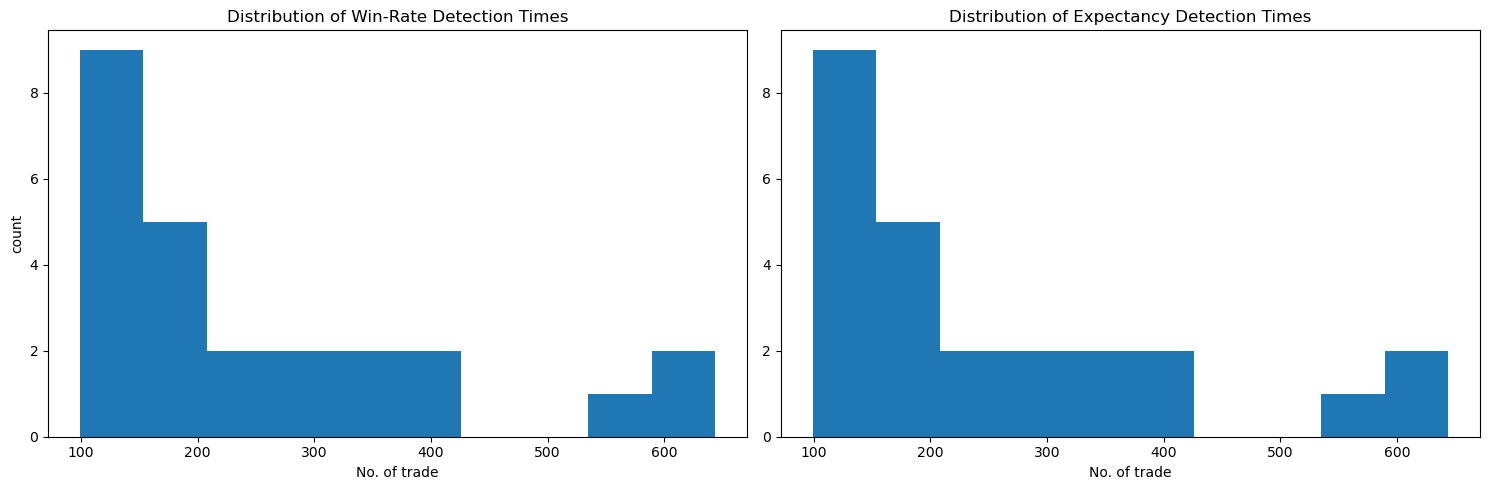

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].hist(win_detection_times, bins=10)
ax[0].set_title("Distribution of Win-Rate Detection Times")
ax[0].set_xlabel('No. of trade')
ax[0].set_ylabel('count')

ax[1].hist(exp_detection_times, bins=10)
ax[1].set_title("Distribution of Expectancy Detection Times")
ax[1].set_xlabel('No. of trade')
plt.tight_layout()
plt.show()


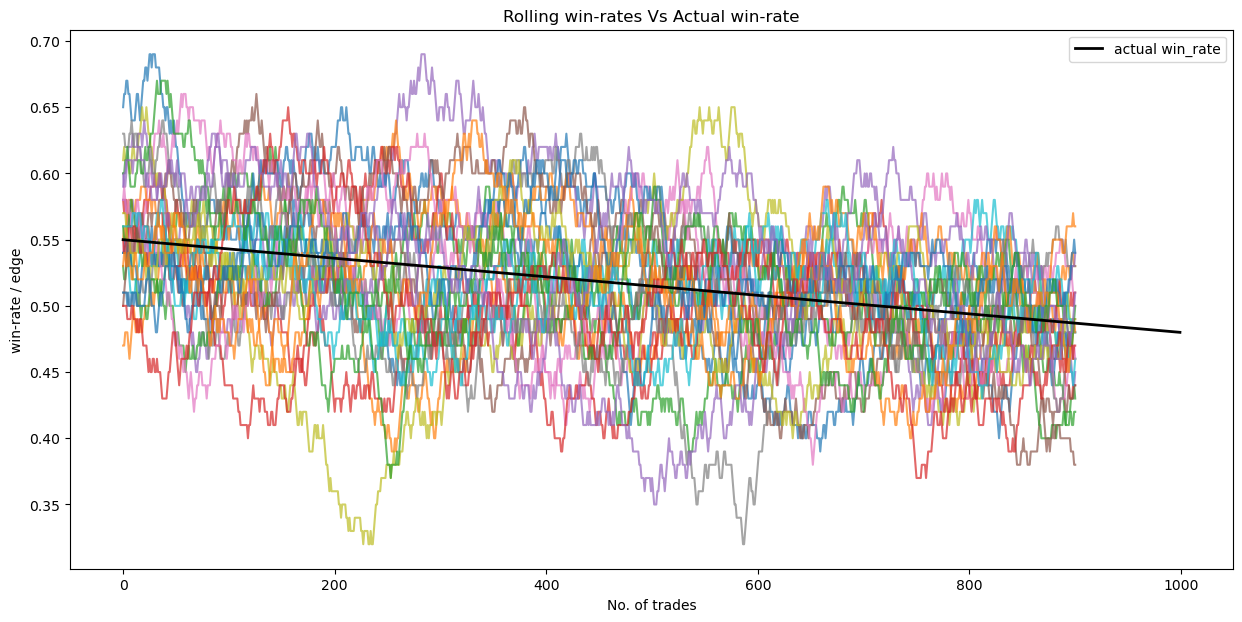

In [10]:
def rolling_win_rate(n_trades = 1000, window = 100):
    t = np.arange(1, n_trades + 1)
    p = 0.55 - (0.07 * (t / 1000))

    seq = np.where(np.random.rand(n_trades) < p, 1, -1)

    equity = np.cumsum(seq)

    # Rolling win rate (overlapping)
    wins = np.where(seq == 1, 1, 0)
    rolling_win = sliding_window_view(wins, window).mean(axis = 1)
    return rolling_win

plt.figure(figsize = (15, 7))
for _ in range(n_runs):
    plt.plot(rolling_win_rate(), alpha = 0.7)

plt.plot(p, label = 'actual win_rate', c = 'black', linewidth = 2)
plt.title('Rolling win-rates Vs Actual win-rate')
plt.xlabel('No. of trades')
plt.ylabel('win-rate / edge')

plt.legend()
plt.show()

# Observations

1. The true win-rate drifts smoothly and gradually from 55% to 48%.
2. Rolling win-rate estimates fluctuate widely around the true value.
3. Rolling metrics frequently cross below 50% long before the true win-rate reaches 50%.
4. Detection timing varies significantly across simulations.
5. Early detection is primarily driven by sampling variance rather than structural degradation.

Key Insight:

In a drifting system, estimator noise often dominates the signal.
Variance creates false structural suspicion well before objective degradation occurs.

Implications:

- Real-time edge estimation is inherently unstable.
- Rolling metrics cannot reliably distinguish noise from slow structural decay.
- Early defensive action may be triggered by variance, not true system failure.
- True edge is never directly observable — only estimated with uncertainty.

Conclusion:

Gradual parameter drift hides inside normal variance.
Detection is probabilistic, delayed, and highly variable across paths.
